In [1]:
import numpy as np
import PIL
import random

import time
from keras.applications import vgg16
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array

from itertools import islice
from tqdm import tqdm
import scipy
from scipy.misc import imresize
from scipy import ndimage

try:
    from io import BytesIO
except ImportError:
    from StringIO import StringIO as BytesIO

from IPython.display import clear_output, Image, display, HTML

Using TensorFlow backend.


In [16]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = load_img(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[-3], x.shape[-2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [3]:
model = vgg16.VGG16(weights='imagenet', include_top=False)
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
print('Model loaded.')

model.summary()

Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0      

In [4]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def showarray(a, fmt='jpeg'):
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

def visstd(a, s=0.1):
    '''Normalize and clip the image range for visualization'''
    a = (a - a.mean()) / max(a.std(), 1e-4) * s + 0.5
    return np.uint8(np.clip(a, 0, 1) * 255)


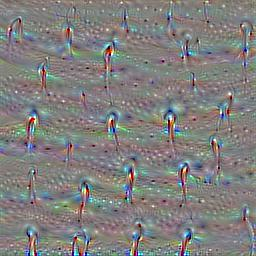

In [23]:
input_img = model.input
filter_index = 7

# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
layer_name = 'block5_conv1'
# we build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
if K.image_data_format() == 'channels_first':
    loss = K.mean(layer_output[:, filter_index, :, :])
else:
    loss = K.mean(layer_output[:, :, :, filter_index])

# we compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads = normalize(grads)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

# step size for gradient ascent
step = 1.

# we start from a gray image with some random noise
if K.image_data_format() == 'channels_first':
    img_data = np.random.uniform(size=(1, 3, 256, 256, 3)) + 128.
else:
    img_data = np.random.uniform(size=(1, 256, 256, 3)) + 128.


# we run gradient ascent for 20 steps
for i in range(50):
    loss_value, grads_value = iterate([img_data])
    img_data += grads_value * step


showarray(visstd(img_data[0]))

In [24]:
sample_size = 100
grid = []
layers = [layer_dict['block%d_conv%d' % (i, (i + 2) // 3)] for i in range(1, 6)]
for layer in layers:
    row = []
    neurons = list(range(max(x or 0 for x in layer.output_shape)))
    if len(neurons) > sample_size:
        neurons = random.sample(neurons, sample_size)
    for neuron in tqdm(neurons, desc=layer.name):
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer.output[:, neuron, :, :])
        else:
            loss = K.mean(layer.output[:, :, :, neuron])
        grads = K.gradients(loss, input_img)[0]
        grads = normalize(grads)
        iterate = K.function([input_img], [loss, grads])
        if K.image_data_format() == 'channels_first':
            img_data = np.random.uniform(size=(1, 3, 128, 128, 3)) + 128.
        else:
            img_data = np.random.uniform(size=(1, 128, 128, 3)) + 128.
        for i in range(25):
            loss_value, grads_value = iterate([img_data])
            img_data += grads_value
        row.append((loss_value, img_data[0]))
    grid.append([cell[1] for cell in islice(sorted(row, key=lambda t: -t[0]), 10)])

block5_conv2: 100%|██████████| 100/100 [01:19<00:00,  1.12it/s]


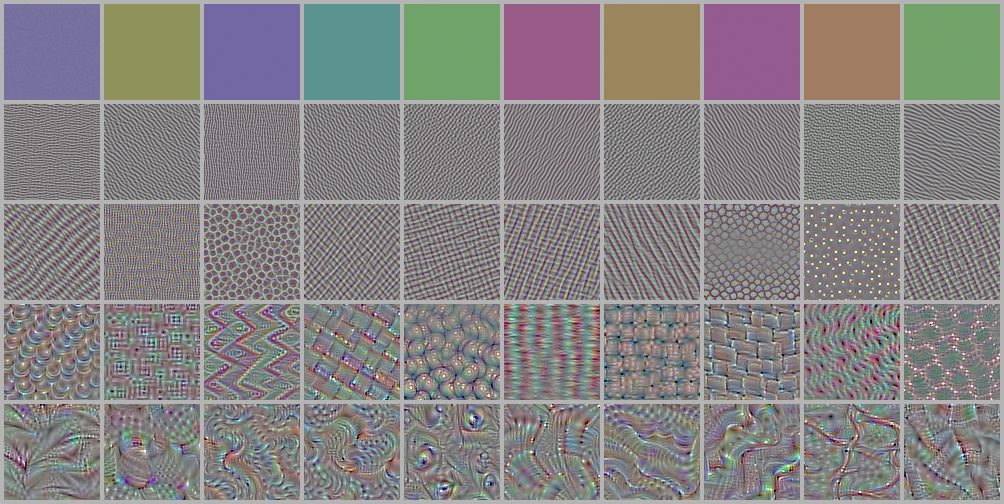

In [25]:
cols = 10
img_grid = PIL.Image.new('RGB', (cols * 100 + 4, len(layers) * 100 + 4), (180, 180, 180))
for y in range(len(layers)):
    for x in range(cols):
        sub = PIL.Image.fromarray(visstd(grid[y][x])).crop((16, 16, 112, 112))
        img_grid.paste(sub, (x * 100 + 4, (y * 100) + 4))
display(img_grid)

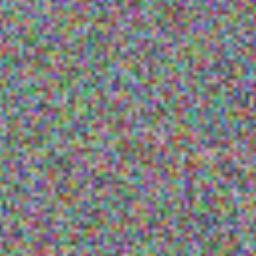

In [26]:
def resize_img(img, size):
    img = np.copy(img)
    if K.image_data_format() == 'channels_first':
        factors = (1, 1,
                   float(size[0]) / img.shape[2],
                   float(size[1]) / img.shape[3])
    else:
        factors = (1,
                   float(size[0]) / img.shape[1],
                   float(size[1]) / img.shape[2],
                   1)
    return scipy.ndimage.zoom(img, factors, order=1)

if K.image_data_format() == 'channels_first':
    img_data = np.random.uniform(size=(3, 64, 64, 3)) + 128.
else:
    img_data = np.random.uniform(size=(64, 64, 3)) + 128.

img2 = resize_img([img_data], (256, 256))
showarray(visstd(img2[0]))

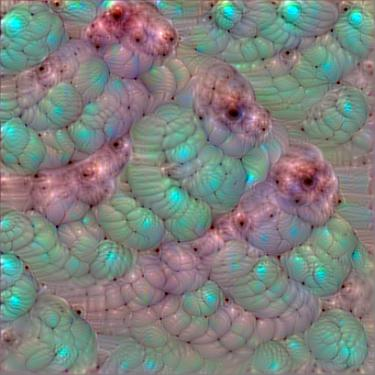

In [27]:
size = 64
if K.image_data_format() == 'channels_first':
    img_data = np.random.uniform(size=(1, 3, size, size)) + 128.
else:
    img_data = np.random.uniform(size=(1, size, size, 3)) + 128.

layer = layer_dict['block5_conv1']
neuron = 4
if K.image_data_format() == 'channels_first':
    loss = K.mean(layer.output[:, neuron, :, :])
else:
    loss = K.mean(layer.output[:, :, :, neuron])
grads = K.gradients(loss, input_img)[0]
grads = normalize(grads)
iterate = K.function([input_img], [loss, grads])

for octave in range(20):
    if octave>0:
        size = int(size * 1.1)
        img_data = resize_img(img_data, (size, size))
    for i in range(10):
        loss_value, grads_value = iterate([img_data])
        img_data += grads_value
    clear_output()
    showarray(visstd(img_data[0]))



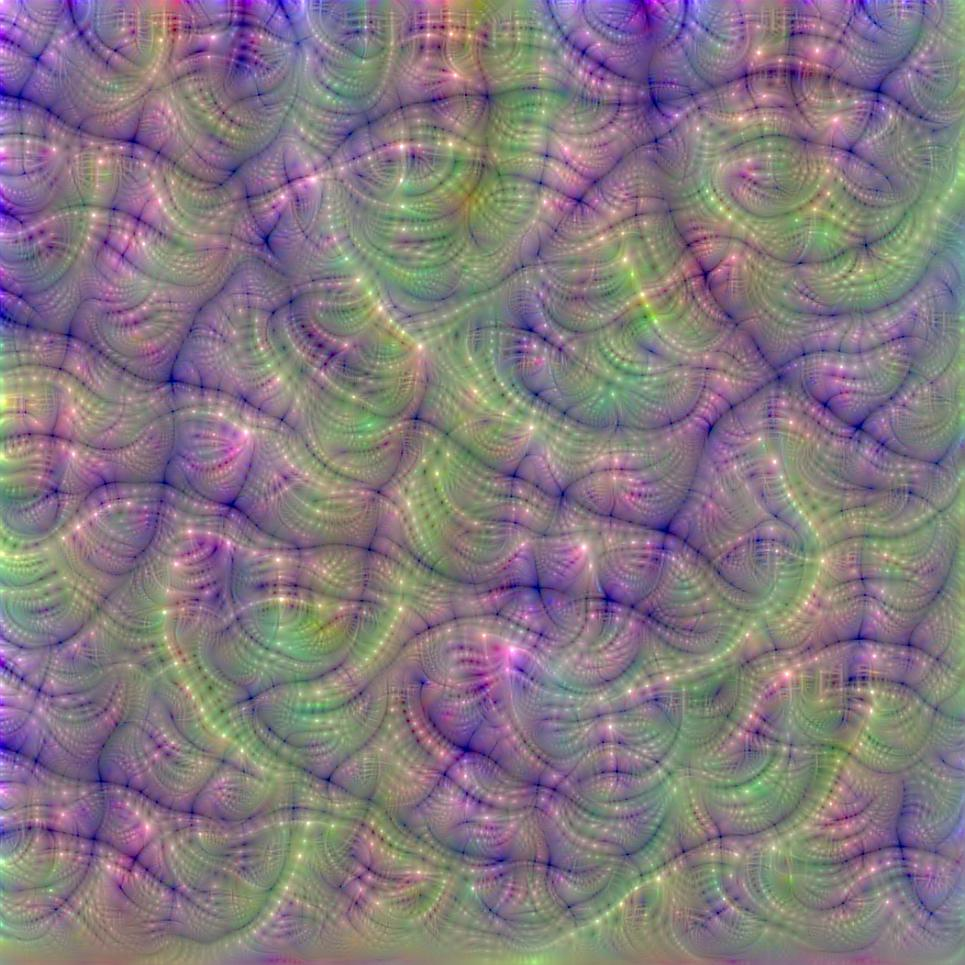

In [28]:
size = 64
if K.image_data_format() == 'channels_first':
    img_data = np.random.uniform(size=(1, 3, size, size)) + 128.
else:
    img_data = np.random.uniform(size=(1, size, size, 3)) + 128.

layer = layer_dict['block5_conv1']

#Things to try: 4, 21, 25, 34, 38, 39, 44, 49, 50
neuron = 53
if K.image_data_format() == 'channels_first':
    loss = K.mean(layer.output[:, neuron, :, :])
else:
    loss = K.mean(layer.output[:, :, :, neuron])
grads = K.gradients(loss, input_img)[0]
grads = normalize(grads)
iterate = K.function([input_img], [loss, grads])

for octave in range(30):
    if octave > 0:
        size = int(size * 1.1)
        img_data = resize_img(img_data, (size, size))
    for i in range(10):
        loss_value, grads_value = iterate([img_data])
        sigma = (1 - octave * 0.03) * 3
        if K.image_data_format() == 'channels_first':
            grads_value[0, 0, :, :] = ndimage.gaussian_filter(grads_value[0, 0, :, :, 0], sigma=sigma)
            grads_value[0, 1, :, :] = ndimage.gaussian_filter(grads_value[0, 1, :, :, 0], sigma=sigma)
            grads_value[0, 2, :, :] = ndimage.gaussian_filter(grads_value[0, 2, :, :, 0], sigma=sigma)
        else:
            grads_value[0, :, :, 0] = ndimage.gaussian_filter(grads_value[0, :, :, 0], sigma=sigma)
            grads_value[0, :, :, 1] = ndimage.gaussian_filter(grads_value[0, :, :, 1], sigma=sigma)
            grads_value[0, :, :, 2] = ndimage.gaussian_filter(grads_value[0, :, :, 2], sigma=sigma)
        img_data += grads_value
    clear_output()
    showarray(visstd(img_data[0]))


In [ ]:
size = 64
if K.image_data_format() == 'channels_first':
    img_data = np.random.uniform(size=(1, 3, size, size)) + 128.
else:
    img_data = np.random.uniform(size=(1, size, size, 3)) + 128.

layer = layer_dict['block5_conv1']
neuron = 4
if K.image_data_format() == 'channels_first':
    loss = K.mean(layer.output[:, neuron, :, :])
else:
    loss = K.mean(layer.output[:, :, :, neuron])
grads = K.gradients(loss, input_img)[0]
grads = normalize(grads)
iterate = K.function([input_img], [loss, grads])

for octave in range(20):
    if octave>0:
        size = int(size * 1.1)
        img_data = resize_img(img_data, (size, size))
    for i in range(10):
        loss_value, grads_value = iterate([img_data])
        if K.image_data_format() == 'channels_first':
            grads_value[0, 0, :, :] = ndimage.gaussian_filter(grads_value[0, 0, :, :, 0], sigma=2)
            grads_value[0, 1, :, :] = ndimage.gaussian_filter(grads_value[0, 1, :, :, 0], sigma=2)
            grads_value[0, 2, :, :] = ndimage.gaussian_filter(grads_value[0, 2, :, :, 0], sigma=2)
        else:
            grads_value[0, :, :, 0] = ndimage.gaussian_filter(grads_value[0, :, :, 0], sigma=2)
            grads_value[0, :, :, 1] = ndimage.gaussian_filter(grads_value[0, :, :, 1], sigma=2)
            grads_value[0, :, :, 2] = ndimage.gaussian_filter(grads_value[0, :, :, 2], sigma=2)
        img_data += grads_value
    clear_output()
    showarray(visstd(img_data[0]))


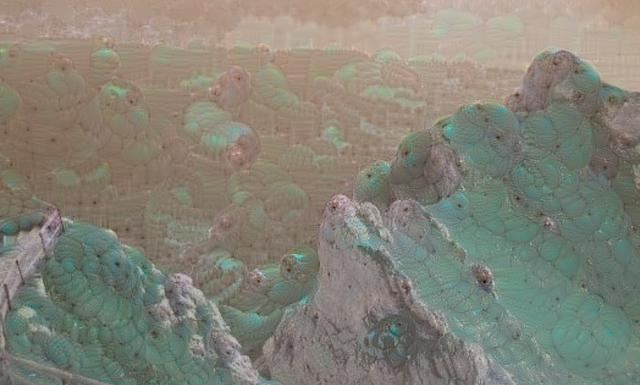

In [32]:
layer = layer_dict['block5_conv1']
neuron = 4
if K.image_data_format() == 'channels_first':
    loss = K.mean(layer.output[:, neuron, :, :])
else:
    loss = K.mean(layer.output[:, :, :, neuron])
grads = K.gradients(loss, input_img)[0]
grads = normalize(grads)
iterate = K.function([input_img], [loss, grads])


num_octave = 5  # Number of scales at which to run gradient ascent
octave_scale = 1.2  # Size ratio between scales

img = preprocess_image('data/pilatus800.jpg')
if K.image_data_format() == 'channels_first':
    original_shape = img.shape[2:]
else:
    original_shape = img.shape[1:3]
successive_shapes = [tuple(int(dim / (octave_scale ** i)) 
                     for dim in original_shape) for i in range(num_octave - 1, -1, -1)]

original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    img = resize_img(img, shape)
    for i in range(20):
        loss_value, grads_value = iterate([img])
        img += grads_value * 0.2
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    clear_output()
    showarray(visstd(img[0]))

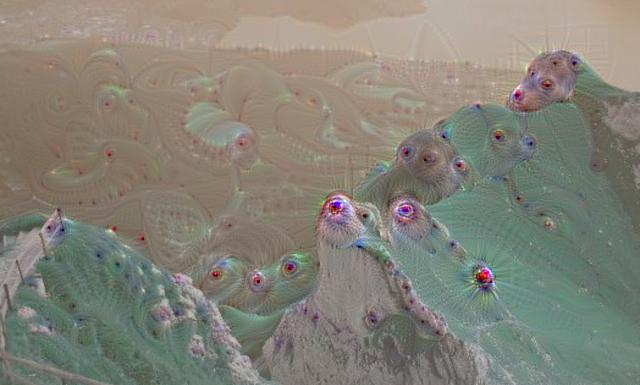

In [41]:
settings = {
        'block3_pool': 0.1,
        'block4_pool': 1.2,
        'block5_pool': 1.5,
}

# Define the loss.
loss = K.variable(0.)
for layer_name, coeff in settings.items():
    x = layer_dict[layer_name].output
    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(x), 'float32'))
    if K.image_data_format() == 'channels_first':
        loss += coeff * K.sum(K.square(x[:, :, 2: -2, 2: -2])) / scaling
    else:
        loss += coeff * K.sum(K.square(x[:, 2: -2, 2: -2, :])) / scaling

grads = K.gradients(loss, input_img)[0]
# grads = normalize(grads)
# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)
iterate = K.function([input_img], [loss, grads])


num_octave = 5  # Number of scales at which to run gradient ascent
octave_scale = 1.2  # Size ratio between scales

img = preprocess_image('data/pilatus800.jpg')
if K.image_data_format() == 'channels_first':
    original_shape = img.shape[2:]
else:
    original_shape = img.shape[1:3]
successive_shapes = [tuple(int(dim / (octave_scale ** i)) 
                     for dim in original_shape) for i in range(num_octave - 1, -1, -1)]

original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    img = resize_img(img, shape)
    for i in range(20):
        loss_value, grads_value = iterate([img])
        img += grads_value * 0.10
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    clear_output()
    showarray(visstd(img[0]))
